In [1]:
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import utils

plt.style.use("ggplot")

# Colours for plots
COLOUR_DICT = {
    "Akvakultur": "royalblue",
    "Jordbruk": "sienna",
    "Avløp": "red",
    "Industri": "darkgrey",
    "Bebygd": "gold",
    "Bakgrunn": "limegreen",
    "Menneskeskapt": "pink",
    "Totalt": "black",
}
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=list(COLOUR_DICT.values()))

# Oslofjord N trends

Jon Lasse would like an overview of nitrogen trends for Oslofjord (TOTN, NO3, DIN etc.) based on both modelling (TEOTIL) and monitoring (Elveovervåkingsprogrammet). See e-mail from Jon Lasse received 22.01.2026.

In [2]:
# Define vassdragsområder for Oslofjord
#  - Inner Oslofjord vassoms 005 to 009
#  - Outer Oslofjord vassoms 001 to 004 and 010 to 014
#  - Whole Oslofjord vassoms 001 to 014
vassom_dict = {
    "Indre Oslofjord": list(range(5, 10)),
    "Ytre Oslofjord": list(range(1, 5)) + list(range(10, 18)),
    "Hele Oslofjord": list(range(1, 18)),
}

## 1. TEOTIL3

TEOTIL3 provides simulations of TOTN and DIN from 2013 to the present. As a starting point, I will use the model to explore trends in N inputs to the Inner, Outer and Whole Oslofjord regions during this period.

### 1.1. User input

In [3]:
# Pars of interest
teo3_pars = ["totn", "din"]

# Period of interest
st_yr, end_yr = 2013, 2023
nve_data_yr = 2024

# Agricultural dataset to use
agri_loss_model = "annual"

### 1.2. Aggregate model results to Oslofjord regions of interest

In [4]:
df_list = []
for area, vassom_list in vassom_dict.items():
    vassom_ids = [f"{i:03d}." for i in vassom_list]
    area_df = utils.get_teotil3_results(
        st_yr,
        end_yr,
        vassom_ids,
        agri_loss_model,
        nve_data_yr,
    )
    for par in teo3_pars:
        par_df = utils.aggregate_parameters(area_df, par).copy()
        par_df["Menneskeskapt"] = (
            par_df["Akvakultur"]
            + par_df["Jordbruk"]
            + par_df["Avløp"]
            + par_df["Industri"]
            + par_df["Bebygd"]
        )
        par_df["Totalt"] = par_df["Menneskeskapt"] + par_df["Bakgrunn"]
        par_df = par_df.groupby("År").sum(numeric_only=True).reset_index()
        par_df["Område"] = area
        par_df["Parameter"] = par.upper()

        df_list.append(par_df)

df = pd.concat(df_list, axis="rows")
id_cols = ["Område", "Parameter", "År"]
value_cols = [col for col in df.columns if col not in id_cols]
df = df[id_cols + value_cols]
df.head()

,Område,Parameter,År,Akvakultur,Jordbruk,Avløp,Industri,Bebygd,Bakgrunn,Menneskeskapt,Totalt
0,Indre Oslofjord,TOTN,2013,0.0,256.997266,1484.387749,105.0,200.674741,204.080641,2047.059756,2251.140398
1,Indre Oslofjord,TOTN,2014,0.0,336.556102,1795.705416,101.6,307.309188,297.834977,2541.170707,2839.005684
2,Indre Oslofjord,TOTN,2015,0.0,274.798950,1955.224502,95.3,294.421910,281.433098,2619.745362,2901.178460
3,Indre Oslofjord,TOTN,2016,0.0,260.097499,1909.219646,98.8,207.466725,210.156669,2475.583869,2685.740538
4,Indre Oslofjord,TOTN,2017,0.0,241.052883,1871.971855,105.5,199.248454,200.488093,2417.773193,2618.261285


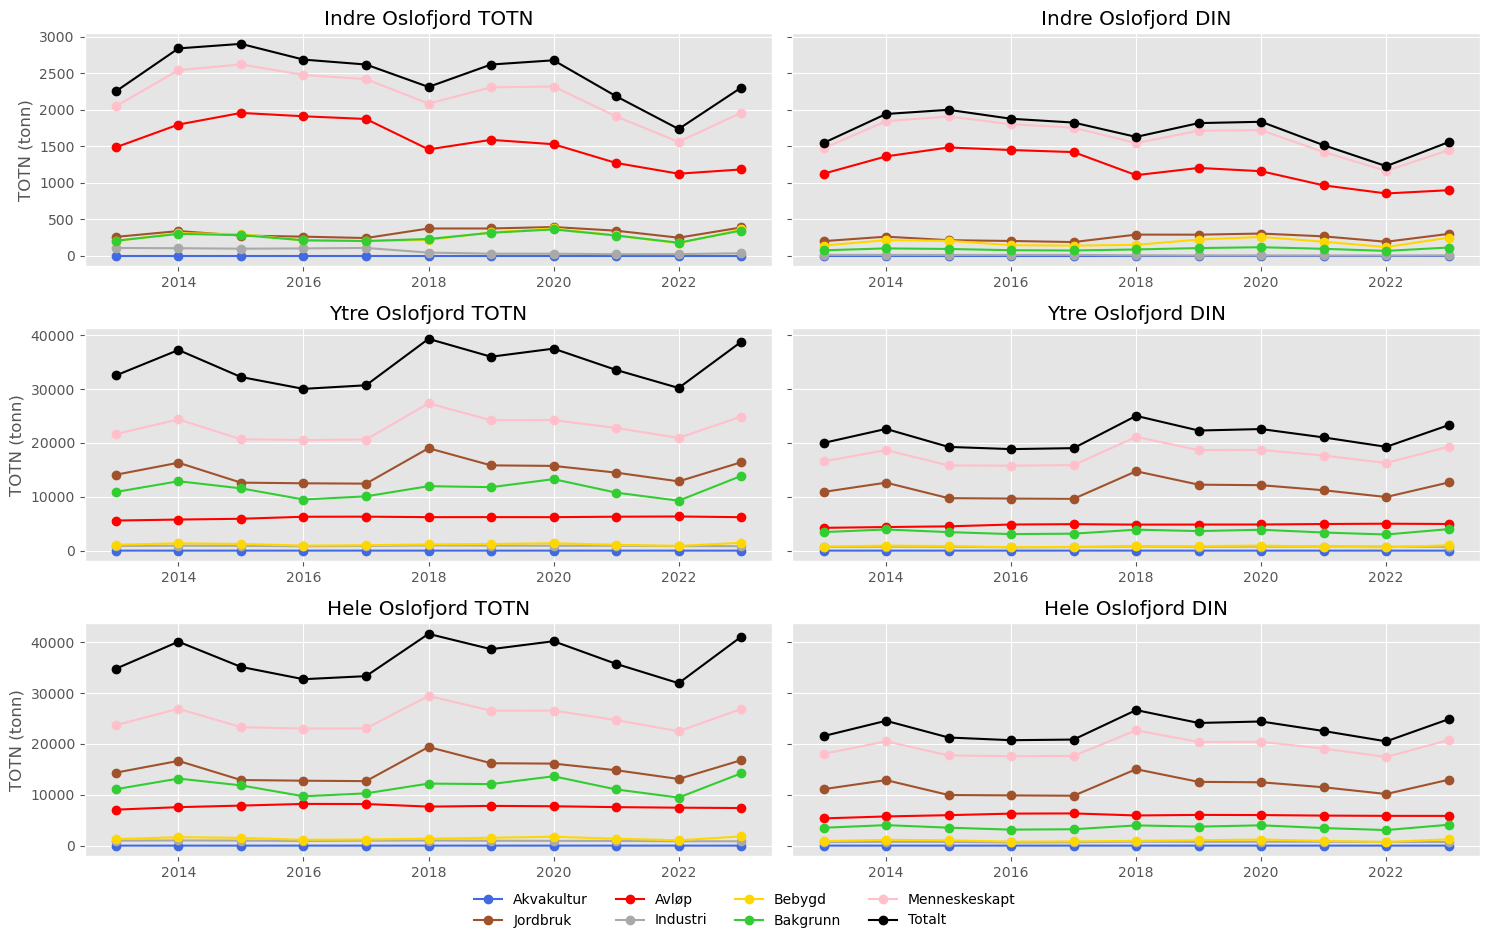

In [5]:
# Plot
nrows = len(vassom_dict.keys())
fig, axes = plt.subplots(nrows=nrows, ncols=2, sharey="row", figsize=(15, nrows * 3))
for row_idx, area in enumerate(vassom_dict.keys()):
    for col_idx, par in enumerate(teo3_pars):
        par = par.upper()
        par_df = df.query("(`Område` == @area) and (Parameter == @par)").copy()
        par_df = par_df.drop(columns=["Område", "Parameter"]).set_index("År")
        par_df.plot(ax=axes[row_idx, col_idx], marker="o", legend=False)
        axes[row_idx, col_idx].set_title(f"{area} {par.upper()}")
        axes[row_idx, col_idx].set_xlabel("")
        axes[row_idx, col_idx].set_ylabel(f"{par.upper()} (tonn)")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=4,
    frameon=False,
    bbox_to_anchor=(0.5, -0.05),
)

plt.tight_layout()

plt.savefig("teo3_oslofjord_loads_2013-2023.png", dpi=200, bbox_inches="tight")

### 1.3. Test for trends

Results from TEOTIL3 (2013 - 2023):
  Indre Oslofjord totn
    Akvakultur: no trend
    Jordbruk: no trend
    Avløp: decreasing
    Industri: decreasing
    Bebygd: no trend
    Bakgrunn: no trend
    Menneskeskapt: decreasing
    Totalt: no trend
  Indre Oslofjord din
    Akvakultur: no trend
    Jordbruk: no trend
    Avløp: decreasing
    Industri: decreasing
    Bebygd: no trend
    Bakgrunn: no trend
    Menneskeskapt: decreasing
    Totalt: no trend
  Ytre Oslofjord totn
    Akvakultur: decreasing
    Jordbruk: no trend
    Avløp: no trend
    Industri: no trend
    Bebygd: no trend
    Bakgrunn: no trend
    Menneskeskapt: no trend
    Totalt: no trend
  Ytre Oslofjord din
    Akvakultur: decreasing
    Jordbruk: no trend
    Avløp: increasing
    Industri: no trend
    Bebygd: no trend
    Bakgrunn: no trend
    Menneskeskapt: no trend
    Totalt: no trend
  Hele Oslofjord totn
    Akvakultur: decreasing
    Jordbruk: no trend
    Avløp: no trend
    Industri: decreasing
    B

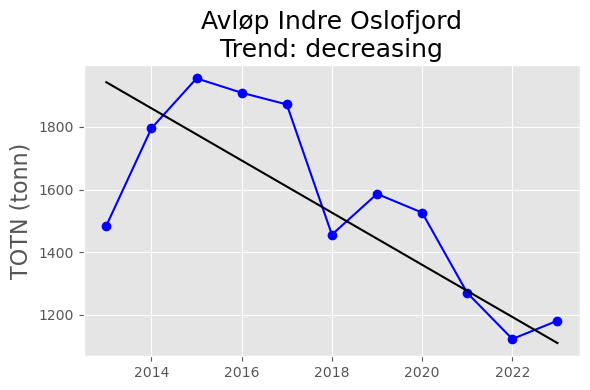

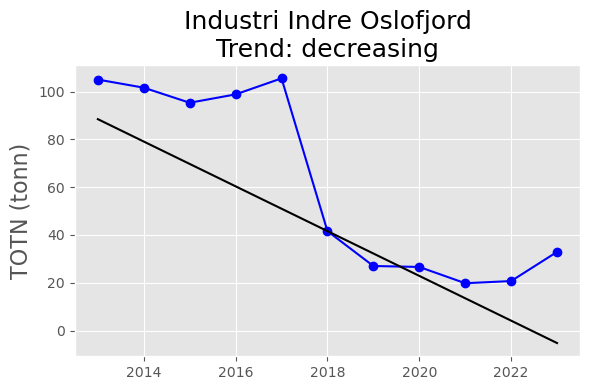

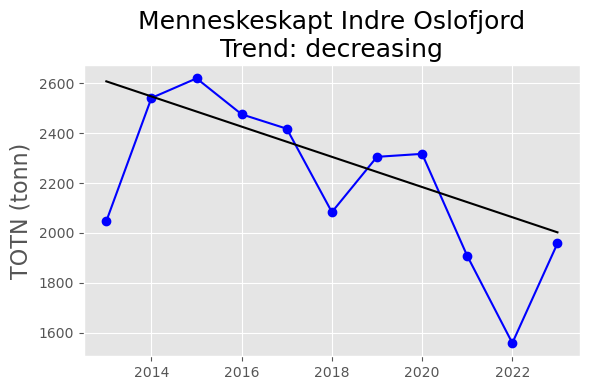

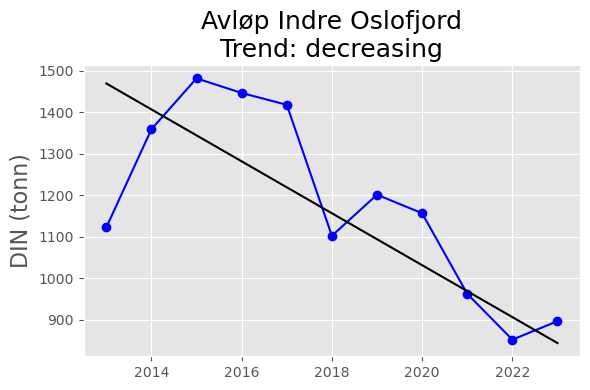

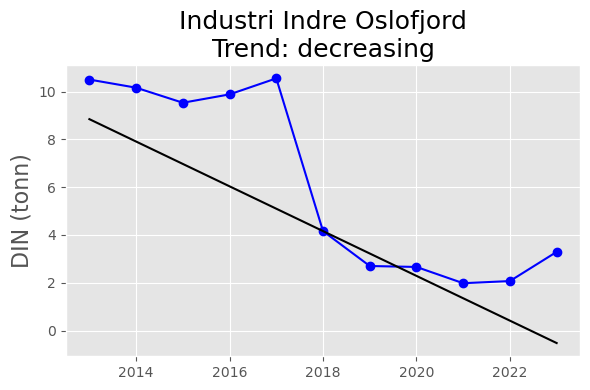

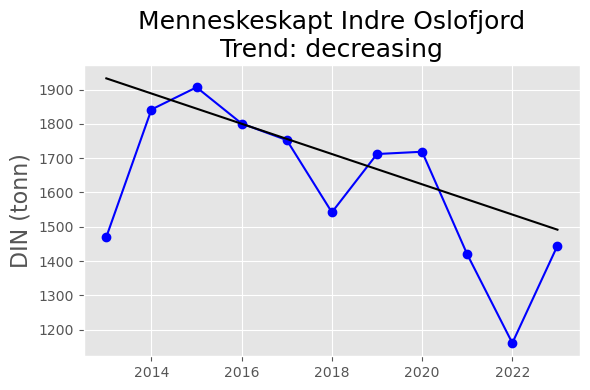

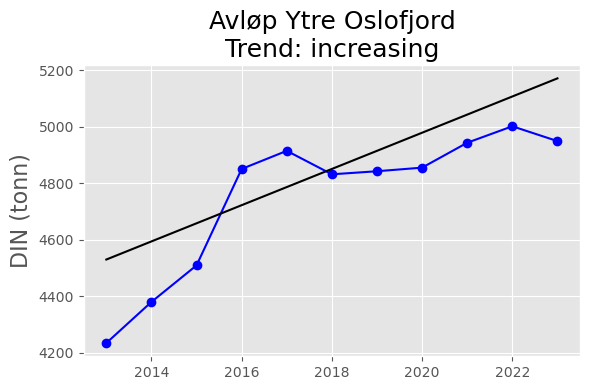

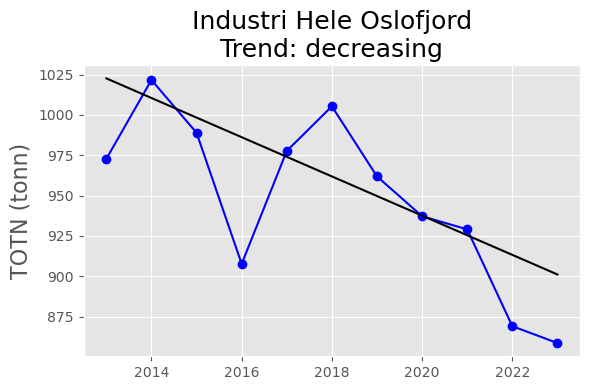

In [6]:
# Test for trends in 'Totalt'
print("Results from TEOTIL3 (2013 - 2023):")
for area in vassom_dict.keys():
    for par in teo3_pars:
        print(f"  {area} {par}")
        for src in value_cols:
            par = par.upper()
            par_df = df.query("(`Område` == @area) and (Parameter == @par)").copy()
            mk_df = nivapy.stats.mk_test(par_df, src, alpha=0.05)
            trend = mk_df.loc["trend", "value"]
            if trend in ("increasing", "decreasing") and (src != "Akvakultur"):
                res_df, sen_df = nivapy.stats.sens_slope(
                    par_df, src, index_col="År", alpha=0.05
                )
                nivapy.plotting.plot_sens_slope(
                    res_df,
                    sen_df,
                    ylabel=f"{par} (tonn)",
                    title=f"{src} {area}\nTrend: {trend}",
                )

            print(f"    {src}: {trend}")

### 1.4. TEOTIL3 summary

According to TEOTIL3, over the period from 2013 to 2023, there are no clear trends in fluxes of TOTN or DIN to either the Inner or Outer Oslofjord regions i.e. **N inputs have remained broadly stable over the past decade**.

## 2. Elveovervåkingsprogrammet

### 2.1. Define monitoring stations around Oslofjord

6 of the Oslofjord's main rivers are monitored as part of Elveovervåkingsprogrammet. The total land area of the Oslofjord catchment is around 85 000 km2. The code below first estimates what proportion of this is covered by the monitoring.

In [7]:
stn_dict = {
    29612: ["Drammenselva", "012.A3"],
    36225: ["Alna", "006.2A0"],
    29613: ["Skienselva", "016.A222"],
    29615: ["Numedalslågen", "015.A1"],
    29617: ["Glomma", "002.A51"],
}
obs_pars = ["totn", "no3-n", "nh4-n"]
osl_cat_area = 85000  # km2

In [8]:
area_df = pd.read_csv(
    f"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve{nve_data_yr}_{st_yr}-{end_yr}_agri-{agri_loss_model}-loss.csv"
)
mon_area = 0
for stn_id, (name, reg_id) in stn_dict.items():
    stn_area_df = area_df.query("(regine == @reg_id)")[
        ["regine", "accum_upstr_area_km2"]
    ]
    mon_area += stn_area_df.iloc[0, 1]

prop_mon = 100 * mon_area / osl_cat_area
print(f"Area monitored: {mon_area:.1f} km2.")
print(
    f"Proportion of Oslofjord catchment covered by monitoring under Elveovervåkingsprogrammet: {prop_mon:.1f} %."
)

Area monitored: 74985.9 km2.
Proportion of Oslofjord catchment covered by monitoring under Elveovervåkingsprogrammet: 88.2 %.


Nearly 90 % of the Oslofjord catchment area is covered by Elveovervåkingsprogrammet. This means we should be able to get a good overview of dominant trends directly from the monitoring data.

### 2.2. Read observed fluxes calculated by Elveovervåkingsprogrammet

In [9]:
# Read observed
obs_path = r"/home/jovyan/shared/common/elveovervakingsprogrammet/results/measured_loads/loads_and_flows_rid_20_1990-2023.csv"
obs_df = pd.read_csv(obs_path)

### 2.3. Compare monitored data to TEOTIL3 results for 2013 to 2023

This is to test TEOTIL3. If the model does a reasonable job of reproducing observed fluxes, we can have more confidence in the simulations for Oslofjord overall (see section 1).

In [10]:
# Calculate 'observed DIN' from NO3 and NH4
obs_df["DIN_tonnes"] = obs_df["NO3-N_tonnes"] + obs_df["NH4-N_tonnes"]

# Get dataset comparing modelled versus observed fluxes
df_list = []
for stn_id, (name, reg_id) in stn_dict.items():
    # Get modelled data
    stn_df_teo3 = utils.get_teotil3_results(
        st_yr, end_yr, [reg_id], agri_loss_model, nve_data_yr
    )
    for par in teo3_pars:
        # Get observed data
        stn_par_df_obs = obs_df.query(
            "(station_id == @stn_id) and (year >= @st_yr) and (year <= @end_yr)"
        )[["station_id", "year", f"{par.upper()}_tonnes"]].copy()
        stn_par_df_obs.columns = ["station_id", "year", "load_tonnes"]
        stn_par_df_obs["par"] = par.upper()
        stn_par_df_obs["name"] = name
        stn_par_df_obs["type"] = "Observed"

        # Get modelled data for par
        stn_par_df_teo3 = utils.aggregate_parameters(stn_df_teo3, par).copy()
        stn_par_df_teo3["Menneskeskapt"] = (
            stn_par_df_teo3["Akvakultur"]
            + stn_par_df_teo3["Jordbruk"]
            + stn_par_df_teo3["Avløp"]
            + stn_par_df_teo3["Industri"]
            + stn_par_df_teo3["Bebygd"]
        )
        stn_par_df_teo3["Totalt"] = (
            stn_par_df_teo3["Menneskeskapt"] + stn_par_df_teo3["Bakgrunn"]
        )
        stn_par_df_teo3 = stn_par_df_teo3[["År", "Totalt"]]
        stn_par_df_teo3.columns = ["year", "load_tonnes"]
        stn_par_df_teo3["par"] = par.upper()
        stn_par_df_teo3["station_id"] = stn_id
        stn_par_df_teo3["name"] = name
        stn_par_df_teo3["type"] = "TEOTIL3"

        df_list.append(stn_par_df_obs)
        df_list.append(stn_par_df_teo3)

comp_df = pd.concat(df_list, axis="rows")[
    ["station_id", "name", "par", "year", "type", "load_tonnes"]
]
comp_df.head()

,station_id,name,par,year,type,load_tonnes
57,29612,Drammenselva,TOTN,2013,Observed,6098.750969
58,29612,Drammenselva,TOTN,2014,Observed,5116.832513
59,29612,Drammenselva,TOTN,2015,Observed,5377.623798
60,29612,Drammenselva,TOTN,2016,Observed,4262.550742
61,29612,Drammenselva,TOTN,2017,Observed,4256.075385


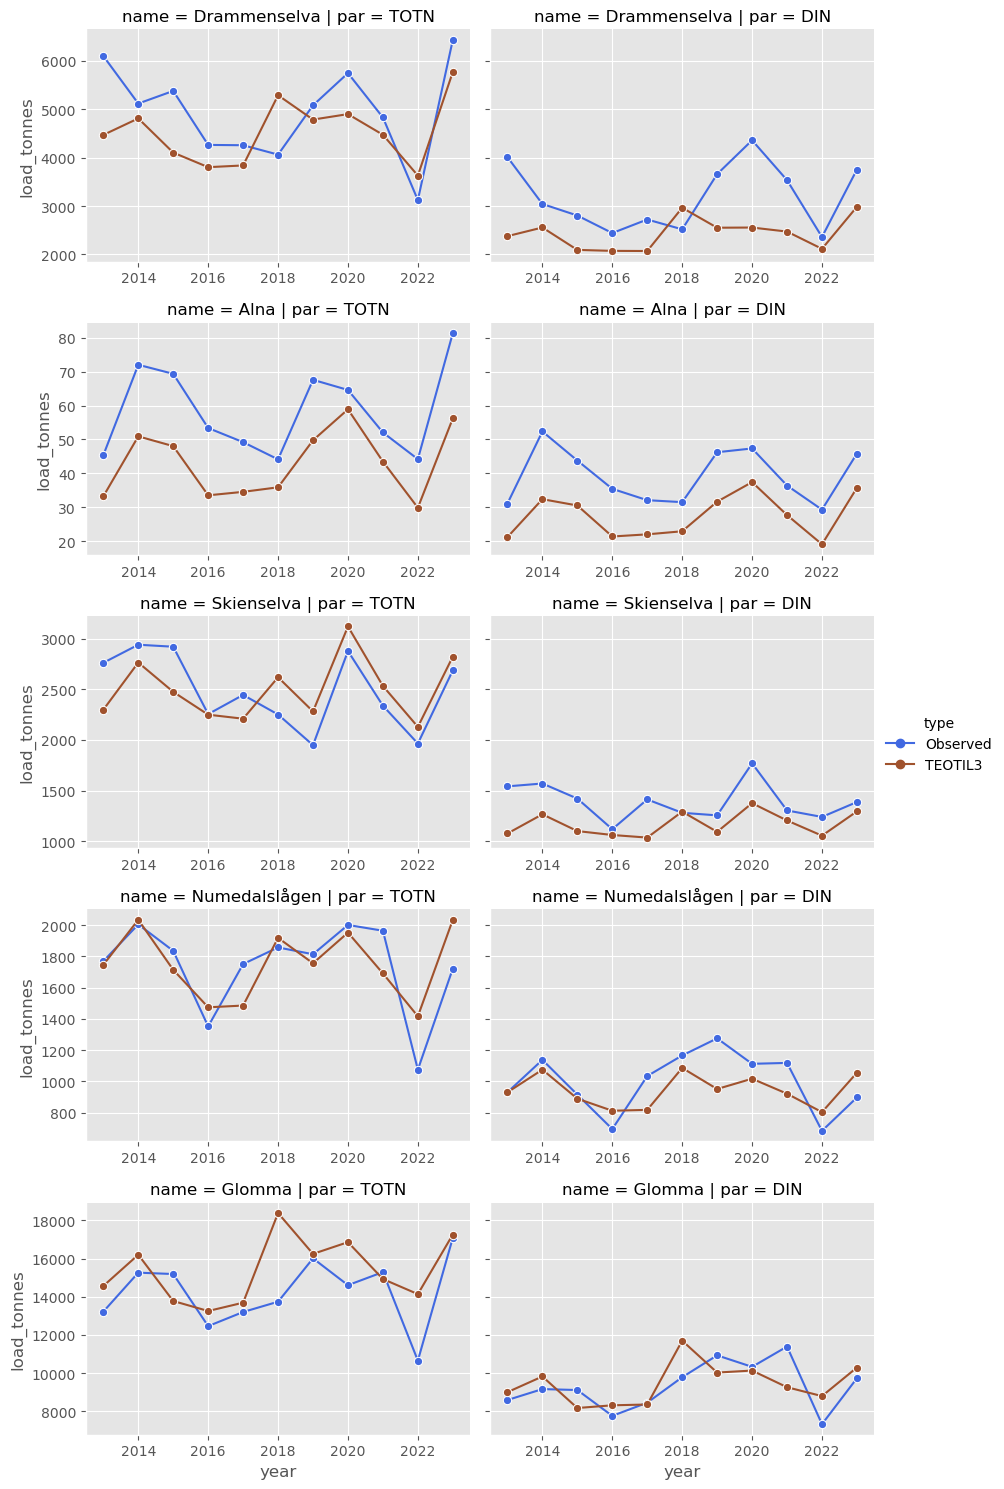

In [11]:
# Plot
sn.relplot(
    data=comp_df,
    x="year",
    y="load_tonnes",
    hue="type",
    row="name",
    col="par",
    kind="line",
    marker="o",
    height=3,
    aspect=1.5,
    facet_kws={"sharey": "row", "sharex": False},
)

plt.savefig("teo3_vs_monitored_2013-2023.png", dpi=200, bbox_inches="tight")

In [12]:
# Test for trends
print("Comparing TEOTIL3 and observed trends for 2013 to 2023:")
for stn_id, (name, reg_id) in stn_dict.items():
    for par in teo3_pars:
        print(f"  {par.upper()} at {name}:")
        for res_type in ["Observed", "TEOTIL3"]:
            par = par.upper()
            res_df = comp_df.query(
                "(station_id == @stn_id) and (par == @par) and (type == @res_type)"
            ).copy()
            mk_df = nivapy.stats.mk_test(res_df, "load_tonnes", alpha=0.05)
            trend = mk_df.loc["trend", "value"]
            print(f"    {res_type} trend: {trend}")

Comparing TEOTIL3 and observed trends for 2013 to 2023:
  TOTN at Drammenselva:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  DIN at Drammenselva:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  TOTN at Alna:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  DIN at Alna:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  TOTN at Skienselva:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  DIN at Skienselva:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  TOTN at Numedalslågen:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  DIN at Numedalslågen:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  TOTN at Glomma:
    Observed trend: no trend
    TEOTIL3 trend: no trend
  DIN at Glomma:
    Observed trend: no trend
    TEOTIL3 trend: no trend


The plots in section 2.3 show that TEOTIL3 does a reasonable job of simulating observed river flows as measured by Elveovervåkingsprogrammet. Statistical analyses of both modelled and observed data series confirm that there are no significant trends in either TOTN or DIN over the past decade. This gives supports the results from section 1 (which consider regions of the Oslofjord, rather than specific rivers).

**Based on this, there is no evidence of significant changes in nitrogen inputs (TOTN or DIN) to any region of the Oslofjord within the past decade**.

## 3. Longer monitoring series

Some of the rivers in Elveovervåkingsprogrammet have data going back to the 1990s. This allows us to consider longer trends, as well as separating NO3 and NH4.

In [13]:
df_list = []
for stn_id, (name, reg_id) in stn_dict.items():
    for par in obs_pars:
        # Get observed data
        stn_par_df_obs = obs_df.query("(station_id == @stn_id)")[
            ["station_id", "year", f"{par.upper()}_tonnes"]
        ].copy()
        stn_par_df_obs.columns = ["station_id", "year", "load_tonnes"]
        stn_par_df_obs["par"] = par.upper()
        stn_par_df_obs["name"] = name
        df_list.append(stn_par_df_obs)

elv_df = pd.concat(df_list, axis="rows")[
    ["station_id", "name", "par", "year", "load_tonnes"]
]
elv_df.head()

,station_id,name,par,year,load_tonnes
34,29612,Drammenselva,TOTN,1990,3227.809787
35,29612,Drammenselva,TOTN,1991,2672.233338
36,29612,Drammenselva,TOTN,1992,3365.366651
37,29612,Drammenselva,TOTN,1993,4076.006047
38,29612,Drammenselva,TOTN,1994,5356.639363


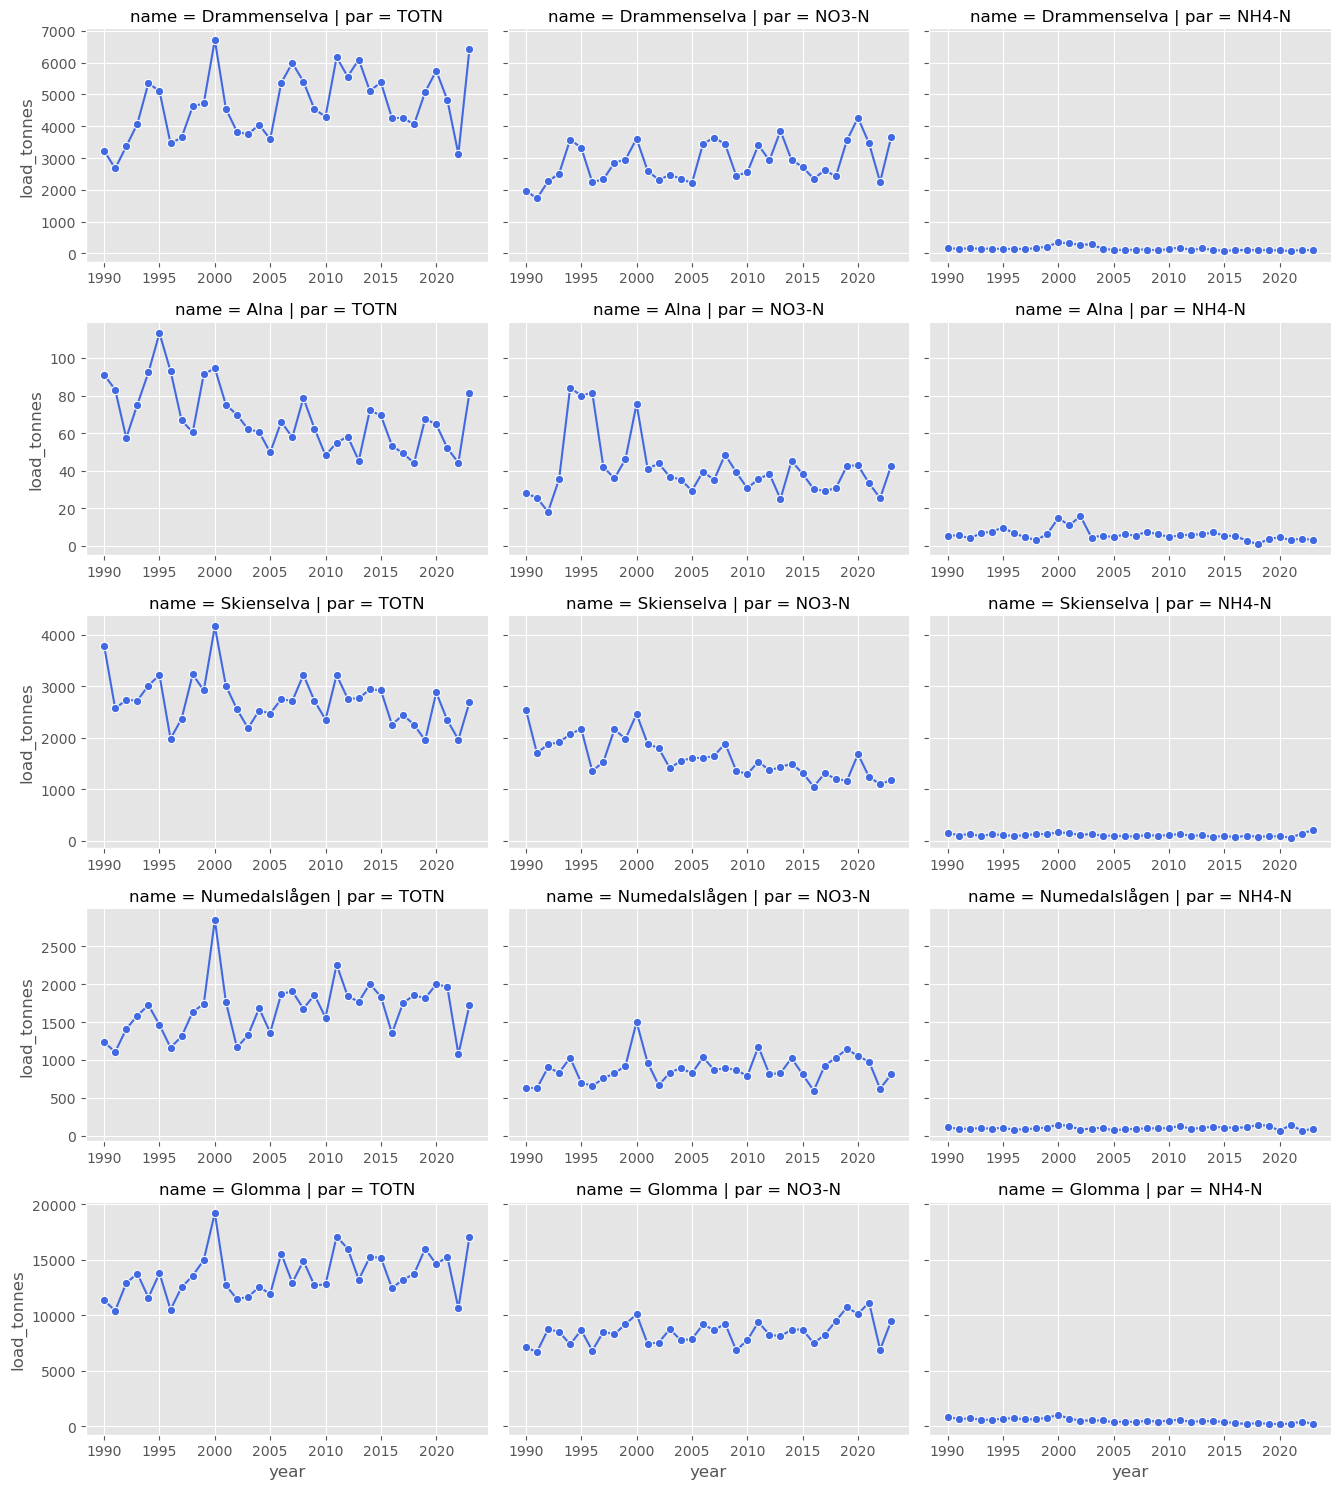

In [14]:
# Plot
sn.relplot(
    data=elv_df,
    x="year",
    y="load_tonnes",
    row="name",
    col="par",
    col_order=[i.upper() for i in obs_pars],
    kind="line",
    marker="o",
    height=3,
    aspect=1.5,
    facet_kws={"sharey": "row", "sharex": False},
)
plt.savefig("monitored_loads_rid_rivers_1990-2023.png", dpi=200, bbox_inches="tight")

In [15]:
# Test for trends
print("Observed trends for 1990 to 2023:")
for stn_id, (name, reg_id) in stn_dict.items():
    print(name)
    for par in obs_pars:
        par = par.upper()
        res_df = elv_df.query("(station_id == @stn_id) and (par == @par)").copy()
        mk_df = nivapy.stats.mk_test(res_df, "load_tonnes", alpha=0.05)
        trend = mk_df.loc["trend", "value"]
        print(f"  {par.upper()}: {trend}")

Observed trends for 1990 to 2023:
Drammenselva
  TOTN: increasing
  NO3-N: increasing
  NH4-N: decreasing
Alna
  TOTN: decreasing
  NO3-N: no trend
  NH4-N: decreasing
Skienselva
  TOTN: decreasing
  NO3-N: decreasing
  NH4-N: decreasing
Numedalslågen
  TOTN: increasing
  NO3-N: no trend
  NH4-N: no trend
Glomma
  TOTN: increasing
  NO3-N: increasing
  NH4-N: decreasing


Over a 30 year period, there are significant trends in the river inputs to Oslofjord. However, the trends are spatially variable. For example, we see generally increasing trends for N in Drammenselva and Glomma, but strong declining trends for Skienselva.

Since the monitoring covers most (88 %) of the Oslofjord catchment, we can create a longer monitoring time series for the Whole Oslofjord by simply summing all the monitoring fluxes. This is done below.

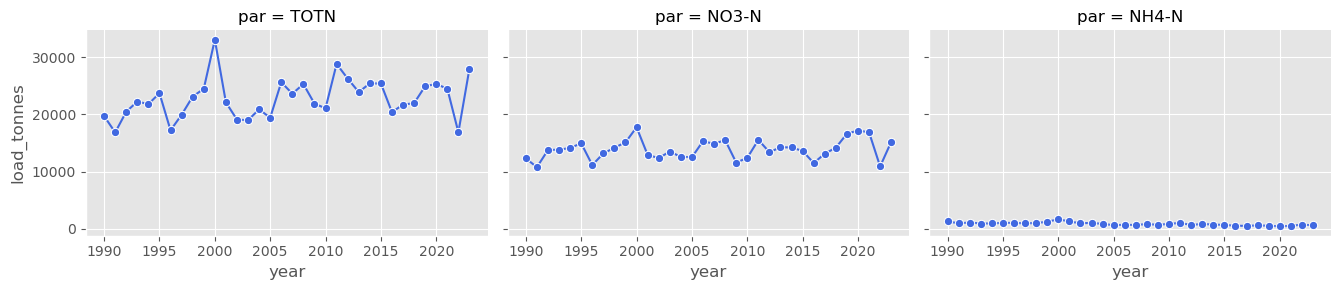

In [16]:
# Combine monitoring data for Oslofjord
osl_df = (
    elv_df.groupby(["par", "year"])
    .sum(numeric_only=True)[["load_tonnes"]]
    .reset_index()
)

# Plot
sn.relplot(
    data=osl_df,
    x="year",
    y="load_tonnes",
    col="par",
    col_order=[i.upper() for i in obs_pars],
    kind="line",
    marker="o",
    height=3,
    aspect=1.5,
    facet_kws={"sharey": "row", "sharex": False},
)
plt.savefig("monitored_loads_oslofjord_1990-2023.png", dpi=200, bbox_inches="tight")


 TOTN


,description,value
var_s,Variance of test statistic,4550.333333
s,M-K test statistic,151.0
z,Normalised test statistic,2.223666
p,p-value of the significance test,0.026171
trend,Type of trend (if present),increasing



 NO3-N


,description,value
var_s,Variance of test statistic,4550.333333
s,M-K test statistic,107.0
z,Normalised test statistic,1.571391
p,p-value of the significance test,0.116092
trend,Type of trend (if present),no trend



 NH4-N


,description,value
var_s,Variance of test statistic,4550.333333
s,M-K test statistic,-329.0
z,Normalised test statistic,-4.862417
p,p-value of the significance test,0.000001
trend,Type of trend (if present),decreasing


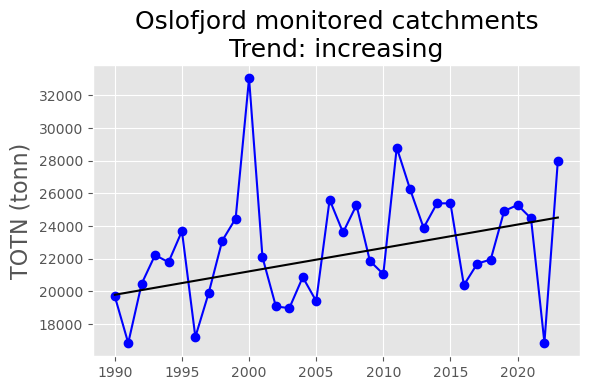

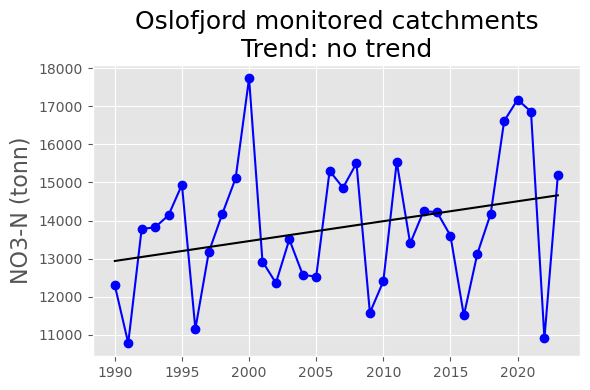

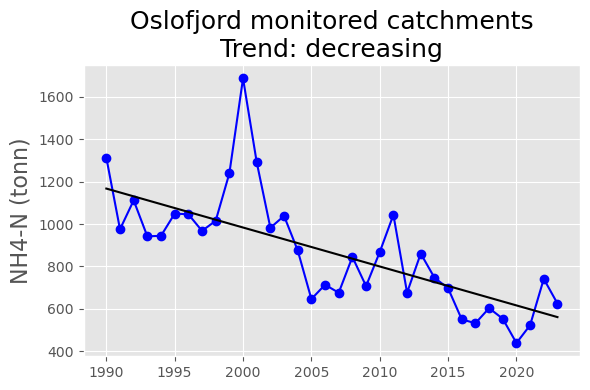

In [17]:
# Test for trends
for par in obs_pars:
    par = par.upper()
    par_df = osl_df.query("par == @par").copy()
    mk_df = nivapy.stats.mk_test(par_df, "load_tonnes", alpha=0.05)
    res_df, sen_df = nivapy.stats.sens_slope(
        par_df, "load_tonnes", index_col="year", alpha=0.05
    )
    trend = mk_df.loc["trend", "value"]
    print("\n", par)
    display(mk_df)
    nivapy.plotting.plot_sens_slope(
        res_df,
        sen_df,
        ylabel=f"{par} (tonn)",
        title=f"Oslofjord monitored catchments\nTrend: {trend}",
    )
    plt.savefig(
        f"monitored_loads_trend_{par.lower()}_1990-2023.png",
        dpi=200,
        bbox_inches="tight",
    )